# Import Library

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import ast
import plotly.express as px

In [63]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Lambda
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA

# Import Dataset Image

In [4]:
def show_image(img, title="", cmap=None):
    plt.figure(figsize=(4, 4))

    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
base_dir = "../..//datasets/final-data" 

all_images = {} 

In [6]:
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):

        images_in_folder = []
        
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(folder_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    images_in_folder.append(img)
        
        if images_in_folder:
            all_images[folder_name] = images_in_folder

list(all_images.keys())

['batik-cendrawasih',
 'batik-bali',
 'batik-betawi',
 'batik-sidoluhur',
 'batik-kawung',
 'batik-garutan',
 'batik-priangan',
 'batik-parang',
 'batik-ciamis',
 'batik-tambal',
 'batik-sogan',
 'batik-pekalongan',
 'batik-gentongan',
 'batik-sidomukti',
 'batik-keraton',
 'batik-lasem',
 'batik-sekar',
 'batik-megamendung',
 'batik-ceplok',
 'batik-celup']

Folder: batik-cendrawasih


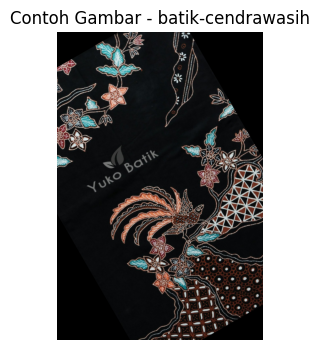

In [7]:
some_folder = list(all_images.keys())[0]
print("Folder:", some_folder)
if all_images[some_folder]:
    sample_img = all_images[some_folder][0]
    show_image(sample_img, title=f"Contoh Gambar - {some_folder}")

# Pre-processing

## Image Size Normalization

In [ ]:
# Fungsi letterbox untuk meresize gambar dengan mempertahankan rasio aspeknya
def letterbox_image(img, target_size=(224, 224), fill_color=(0, 0, 0)):
    h, w = img.shape[:2]
    target_w, target_h = target_size

    # Hitung faktor skala agar gambar muat di dalam target tanpa mengubah rasio aspeknya
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize gambar sesuai dengan skala yang dihitung
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Buat kanvas target dengan ukuran (224,224) dan isi dengan fill_color
    if len(img.shape) == 3:  # Gambar berwarna (BGR)
        canvas = np.full((target_h, target_w, 3), fill_color, dtype=resized.dtype)
    else:  # Gambar grayscale
        canvas = np.full((target_h, target_w), fill_color[0], dtype=resized.dtype)

    # Hitung offset agar gambar ditempatkan di tengahc
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # Tempelkan gambar ke kanvas
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

In [9]:
target_size = (224, 224)
resized_images = {}

for folder_name, img_list in all_images.items():
    resized_list = []
    for img in img_list:
        img_letterboxed = letterbox_image(img, target_size=target_size, fill_color=(0, 0, 0))
        resized_list.append(img_letterboxed)
    resized_images[folder_name] = resized_list

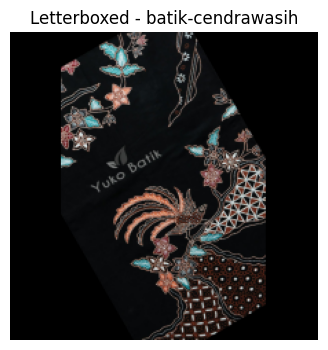

Ukuran gambar letterboxed: (224, 224, 3)


In [10]:
some_folder = list(resized_images.keys())[0]
sample_img = resized_images[some_folder][0]
show_image(sample_img, title=f"Letterboxed - {some_folder}")
print("Ukuran gambar letterboxed:", sample_img.shape)

## Convert to Grayscale

In [11]:
grayscale_images = {}

for folder_name, img_list in resized_images.items():
    gray_list = []
    for img in img_list:
        # Konversi gambar (yang berukuran 224x224 dengan padding) ke grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_list.append(img_gray)
    grayscale_images[folder_name] = gray_list

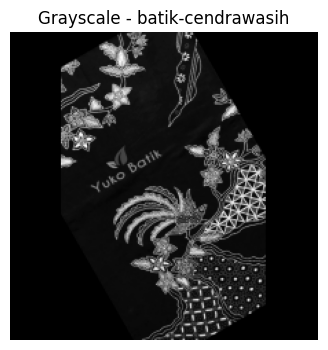

Ukuran gambar grayscale: (224, 224)


In [12]:
some_folder = list(grayscale_images.keys())[0]
sample_gray = grayscale_images[some_folder][0]
show_image(sample_gray, title=f"Grayscale - {some_folder}", cmap='gray')
print("Ukuran gambar grayscale:", sample_gray.shape)

## Pixel Normalization

In [13]:
normalized_gray_images = {}

for folder_name, img_list in grayscale_images.items():
    norm_list = []
    for img in img_list:
        # Ubah tipe data ke float32 dan normalisasi ke rentang [0, 1]
        img_norm = img.astype(np.float32) / 255.0
        norm_list.append(img_norm)
    normalized_gray_images[folder_name] = norm_list

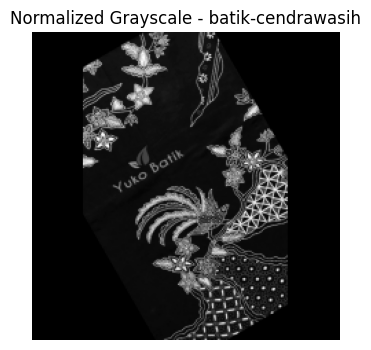

Nilai piksel: min = 0.0 max = 0.88235295
Ukuran gambar normalized grayscale: (224, 224)


In [14]:
sample_norm_gray = normalized_gray_images[some_folder][0]
show_image(sample_norm_gray, title=f"Normalized Grayscale - {some_folder}", cmap='gray')
print("Nilai piksel: min =", sample_norm_gray.min(), "max =", sample_norm_gray.max())
print("Ukuran gambar normalized grayscale:", sample_norm_gray.shape)

# Feature Extraction

## Convert Image to 3 Channel

In [15]:
def to_three_channels(img):
    if len(img.shape) == 2:
        return np.stack((img,)*3, axis=-1)
    elif img.shape[2] == 1:
        return np.concatenate([img, img, img], axis=-1)
    else:
        return img

## Embedding Extraction

In [16]:
# Definisikan model ekstraksi fitur:
# Gunakan ResNet50 tanpa bagian top (fully connected), kemudian global average pooling dan dense layer 256 unit.
input_tensor = Input(shape=(224, 224, 3))
# Gunakan pre-trained ResNet50 dengan include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
feature_extractor = Model(inputs=input_tensor, outputs=x)

In [17]:
print(feature_extractor.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 24,059,136 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [18]:
extracted_features = {}

# Iterasi setiap folder
for folder_name, img_list in normalized_gray_images.items():
    folder_features = []
    for img in img_list:
        # Jika gambar grayscale (shape (224,224)), ubah ke 3 channel (224,224,3)
        if len(img.shape) == 2 or (len(img.shape)==3 and img.shape[2]==1):
            img_3ch = to_three_channels(img)
        else:
            img_3ch = img
        # Pastikan tipe data float32 dan rentang nilai [0, 1]
        img_3ch = img_3ch.astype(np.float32)
        # Jika perlu, Anda bisa mengubah rentang menggunakan preprocess_input:
        # img_input = tf.keras.applications.resnet50.preprocess_input(img_3ch * 255.0)
        # Namun di sini, misalkan kita gunakan langsung nilai [0,1].
        # Model pre-trained ImageNet umumnya membutuhkan rentang dan preprocessing khusus,
        # sehingga Anda bisa menyesuaikan sesuai kebutuhan.
        
        # Ubah dimensi (224,224,3) menjadi (1,224,224,3) untuk prediksi
        img_input = np.expand_dims(img_3ch, axis=0)
        # Ekstraksi fitur
        features = feature_extractor.predict(img_input)
        # Hasilnya: array shape (1, 256). Ambil vektor fitur
        folder_features.append(features[0])
    extracted_features[folder_name] = folder_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 

In [19]:
some_folder = list(extracted_features.keys())[0]
sample_feature = extracted_features[some_folder][0]
print(f"Contoh vektor fitur dari folder {some_folder}:", sample_feature)
print("Dimensi vektor fitur:", sample_feature.shape)

Contoh vektor fitur dari folder batik-cendrawasih: [0.         0.         0.76512635 0.28080267 0.         0.
 0.         0.         0.14626548 0.         0.         0.
 0.         0.43942407 0.         0.         0.         0.
 0.13489017 0.6370328  0.         0.         0.         0.
 0.         0.         1.4573793  0.         0.         0.
 0.97532314 0.21656892 0.08359034 0.11831912 0.72524047 0.0238515
 0.         0.40544748 0.         0.05001977 0.         0.8354455
 0.         0.         0.06275016 0.         0.         0.03967475
 0.         0.         0.09313037 0.         0.         0.96961725
 0.         0.19329813 1.7535167  0.         0.         0.
 1.0655342  0.         0.         1.1146674  0.         0.9896446
 0.22019403 0.5278508  0.         0.         0.28556332 0.
 0.92667603 1.0214511  0.8044     0.27448028 0.09759182 0.25874597
 1.1336297  1.1378076  0.92431104 0.         0.         0.
 0.         0.3326517  0.79987687 0.         0.5737784  0.53675765
 0.        

## Save Embedding Extraction

In [20]:
features_serializable = {folder: [vec.tolist() for vec in feats] for folder, feats in extracted_features.items()}

with open('../../datasets/in-procces/data_image_batik_embed.json', 'w') as f:
    json.dump(features_serializable, f)
#

## Save Model

In [21]:
feature_extractor.save("../../models/resnet50-globalaveragepooling-256dense.keras")

# Image Embed Aggregation for Each Type 

In [22]:
aggregated_features = {}

for category, embedding_list in extracted_features.items():
    # Gabungkan list embedding menjadi array dengan shape (n_gambar, 256)
    embeddings_array = np.stack(embedding_list, axis=0)
    # Lakukan average pooling (rata-rata) sepanjang axis gambar
    aggregated_vector = np.mean(embeddings_array, axis=0)
    aggregated_features[category] = aggregated_vector

In [23]:
if "batik-cendrawasih" in aggregated_features:
    print("Aggregated vector for batik-cendrawasih:")
    print(aggregated_features["batik-cendrawasih"])
    print("Shape:", aggregated_features["batik-cendrawasih"].shape)
else:
    print("Kategori 'batik-cendrawasih' tidak ditemukan dalam extracted_features.")

Aggregated vector for batik-cendrawasih:
[0.00000000e+00 0.00000000e+00 7.52231836e-01 2.53526568e-01
 0.00000000e+00 0.00000000e+00 1.55849406e-03 0.00000000e+00
 1.60630226e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.81210029e-01 0.00000000e+00 1.03270337e-02
 0.00000000e+00 0.00000000e+00 1.21354446e-01 6.23924136e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25784636e-03
 0.00000000e+00 1.59296405e-03 1.44615793e+00 2.75973207e-03
 0.00000000e+00 0.00000000e+00 9.47146118e-01 1.90152436e-01
 1.00366034e-01 1.43185154e-01 7.14754879e-01 2.76080370e-02
 0.00000000e+00 4.17015731e-01 0.00000000e+00 7.86272958e-02
 2.13344712e-02 8.41796994e-01 0.00000000e+00 0.00000000e+00
 7.27031752e-02 0.00000000e+00 0.00000000e+00 5.24087138e-02
 0.00000000e+00 0.00000000e+00 1.41404882e-01 0.00000000e+00
 0.00000000e+00 9.93880212e-01 0.00000000e+00 1.92263067e-01
 1.76704431e+00 0.00000000e+00 0.00000000e+00 8.60091008e-04
 9.98174429e-01 0.00000000e+00 0.00000000e+0

## Save Embed Aggregation

In [24]:
df_aggregated = pd.DataFrame.from_dict(aggregated_features, orient='index')

In [25]:
df_aggregated.columns = [f'feature_{i+1}' for i in range(df_aggregated.shape[1])]

df_aggregated['preprocessing_embedding'] = df_aggregated.apply(lambda row: str(list(row.values)), axis=1)

df_aggregated = df_aggregated[['preprocessing_embedding']]

In [ ]:
df_aggregated

,preprocessing_embedding
batik-cendrawasih,"[0.0, 0.0, 0.75223184, 0.25352657, 0.0, 0.0, 0..."
batik-bali,"[0.0, 0.0, 0.5472957, 0.4215742, 0.0, 0.0, 0.0..."
batik-betawi,"[0.0, 0.0, 0.6672203, 0.40276045, 0.0, 0.0, 0...."
batik-sidoluhur,"[0.0, 0.0, 0.64312387, 0.33181974, 0.0, 0.0, 0..."
batik-kawung,"[0.010028688, 0.0, 0.17821598, 0.7098277, 0.0,..."
batik-garutan,"[0.0, 0.0, 0.5868656, 0.40083218, 0.0, 0.0, 0...."
batik-priangan,"[0.0, 0.0, 0.6487553, 0.35312605, 0.0, 0.0, 0...."
batik-parang,"[0.00034279638, 0.0, 0.3473972, 0.63084286, 0...."
batik-ciamis,"[0.0, 0.0, 0.6932021, 0.36210075, 0.0, 0.0, 8...."
batik-tambal,"[0.0, 0.0, 0.6715081, 0.3345668, 0.0, 0.0, 0.0..."


In [ ]:
df_aggregated.to_csv("../../datasets/in-procces/data_image_batik_embed_aggregation.csv", index_label="batik_category")


In [45]:
df_aggregated = pd.read_csv("../../datasets/in-procces/data_image_batik_embed_aggregation.csv")

In [46]:
# Pastikan nama kolom yang ingin diubah ada dalam dataset
old_col_name = "batik_category"  # Sesuaikan dengan nama yang sebenarnya jika berbeda
if old_col_name in df_aggregated.columns:
    df_aggregated.rename(columns={old_col_name: "Nama"}, inplace=True)
    
# Bersihkan data di kolom "Nama"
df_aggregated["Nama"] = df_aggregated["Nama"].str.replace("-", " ")  # Hilangkan tanda strip
df_aggregated["Nama"] = df_aggregated["Nama"].str.title()  # Ubah huruf pertama menjadi kapital

df_aggregated.sort_values(by="Nama", inplace=True)

In [47]:
output_path = "cleaned_data_image_batik_embed_aggregation.csv"
df_x.to_csv(output_path, index=False)

In [48]:
df_aggregated

,Unnamed: 0,Nama,preprocessing_embedding
0,1,Batik Bali,"[0.0, 0.0, 0.5472957, 0.4215742, 0.0, 0.0, 0.0..."
1,2,Batik Betawi,"[0.0, 0.0, 0.6672203, 0.40276045, 0.0, 0.0, 0...."
2,19,Batik Celup,"[0.0, 0.0, 0.79459745, 0.39430383, 0.0, 0.0, 0..."
3,0,Batik Cendrawasih,"[0.0, 0.0, 0.75223184, 0.25352657, 0.0, 0.0, 0..."
4,18,Batik Ceplok,"[0.0004699176, 0.0, 0.6311944, 0.42550611, 0.0..."
5,8,Batik Ciamis,"[0.0, 0.0, 0.6932021, 0.36210075, 0.0, 0.0, 8...."
6,5,Batik Garutan,"[0.0, 0.0, 0.5868656, 0.40083218, 0.0, 0.0, 0...."
7,12,Batik Gentongan,"[0.0, 0.0, 0.6754523, 0.37115434, 0.0, 0.0, 0...."
8,4,Batik Kawung,"[0.010028688, 0.0, 0.17821598, 0.7098277, 0.0,..."
9,14,Batik Keraton,"[0.00027843774, 0.0, 0.3422289, 0.5955038, 0.0..."


In [49]:
df_aggregated.to_csv("../../datasets/in-procces/data_image_batik_embed_aggregation.csv", index="False")

In [50]:
data = pd.read_csv("../../datasets/in-procces/data_image_batik_embed_aggregation.csv")

In [51]:
data

,Unnamed: 0.1,Unnamed: 0,Nama,preprocessing_embedding
0,0,1,Batik Bali,"[0.0, 0.0, 0.5472957, 0.4215742, 0.0, 0.0, 0.0..."
1,1,2,Batik Betawi,"[0.0, 0.0, 0.6672203, 0.40276045, 0.0, 0.0, 0...."
2,2,19,Batik Celup,"[0.0, 0.0, 0.79459745, 0.39430383, 0.0, 0.0, 0..."
3,3,0,Batik Cendrawasih,"[0.0, 0.0, 0.75223184, 0.25352657, 0.0, 0.0, 0..."
4,4,18,Batik Ceplok,"[0.0004699176, 0.0, 0.6311944, 0.42550611, 0.0..."
5,5,8,Batik Ciamis,"[0.0, 0.0, 0.6932021, 0.36210075, 0.0, 0.0, 8...."
6,6,5,Batik Garutan,"[0.0, 0.0, 0.5868656, 0.40083218, 0.0, 0.0, 0...."
7,7,12,Batik Gentongan,"[0.0, 0.0, 0.6754523, 0.37115434, 0.0, 0.0, 0...."
8,8,4,Batik Kawung,"[0.010028688, 0.0, 0.17821598, 0.7098277, 0.0,..."
9,9,14,Batik Keraton,"[0.00027843774, 0.0, 0.3422289, 0.5955038, 0.0..."


In [55]:
# Drop kolom "Unnamed" yang tidak diperlukan
df_cleaned = data[["Nama", "preprocessing_embedding"]]

# Simpan hasil ke file CSV baru
cleaned_output_path = "../../datasets/in-procces/data_image_batik_embed_aggregation.csv"
df_cleaned.to_csv(cleaned_output_path, index=False)

# Tampilkan hasil setelah pembersihan
df_cleaned

,Nama,preprocessing_embedding
0,Batik Bali,"[0.0, 0.0, 0.5472957, 0.4215742, 0.0, 0.0, 0.0..."
1,Batik Betawi,"[0.0, 0.0, 0.6672203, 0.40276045, 0.0, 0.0, 0...."
2,Batik Celup,"[0.0, 0.0, 0.79459745, 0.39430383, 0.0, 0.0, 0..."
3,Batik Cendrawasih,"[0.0, 0.0, 0.75223184, 0.25352657, 0.0, 0.0, 0..."
4,Batik Ceplok,"[0.0004699176, 0.0, 0.6311944, 0.42550611, 0.0..."
5,Batik Ciamis,"[0.0, 0.0, 0.6932021, 0.36210075, 0.0, 0.0, 8...."
6,Batik Garutan,"[0.0, 0.0, 0.5868656, 0.40083218, 0.0, 0.0, 0...."
7,Batik Gentongan,"[0.0, 0.0, 0.6754523, 0.37115434, 0.0, 0.0, 0...."
8,Batik Kawung,"[0.010028688, 0.0, 0.17821598, 0.7098277, 0.0,..."
9,Batik Keraton,"[0.00027843774, 0.0, 0.3422289, 0.5955038, 0.0..."


# Visualization

In [56]:
df_vi = pd.read_csv('../../datasets/in-procces/data_image_batik_embed_aggregation.csv')

In [57]:
df_vi

,Nama,preprocessing_embedding
0,Batik Bali,"[0.0, 0.0, 0.5472957, 0.4215742, 0.0, 0.0, 0.0..."
1,Batik Betawi,"[0.0, 0.0, 0.6672203, 0.40276045, 0.0, 0.0, 0...."
2,Batik Celup,"[0.0, 0.0, 0.79459745, 0.39430383, 0.0, 0.0, 0..."
3,Batik Cendrawasih,"[0.0, 0.0, 0.75223184, 0.25352657, 0.0, 0.0, 0..."
4,Batik Ceplok,"[0.0004699176, 0.0, 0.6311944, 0.42550611, 0.0..."
5,Batik Ciamis,"[0.0, 0.0, 0.6932021, 0.36210075, 0.0, 0.0, 8...."
6,Batik Garutan,"[0.0, 0.0, 0.5868656, 0.40083218, 0.0, 0.0, 0...."
7,Batik Gentongan,"[0.0, 0.0, 0.6754523, 0.37115434, 0.0, 0.0, 0...."
8,Batik Kawung,"[0.010028688, 0.0, 0.17821598, 0.7098277, 0.0,..."
9,Batik Keraton,"[0.00027843774, 0.0, 0.3422289, 0.5955038, 0.0..."


In [58]:
def parse_embedding(x):
    return np.array(ast.literal_eval(x))

In [61]:
embeddings = df_vi['preprocessing_embedding'].apply(parse_embedding)
embeddings_array = np.vstack(embeddings.values)

In [64]:
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings_array)

In [65]:
df_vi['PCA1'] = embeddings_2d[:, 0]
df_vi['PCA2'] = embeddings_2d[:, 1]

# Buat visualisasi dengan Plotly Express
fig = px.scatter(
    df_vi, 
    x='PCA1', 
    y='PCA2', 
    text='Nama',  # Label setiap titik dengan nama batik
    color='Nama',  # Warna berbeda untuk setiap jenis batik
    title="Visualisasi 2D Embedding dengan Label Nama Batik (PCA)",
    labels={'PCA1': "Komponen Utama 1", 'PCA2': "Komponen Utama 2"},
    width=900,  # Lebar plot
    height=700  # Tinggi plot
)

# Tambahkan label titik
fig.update_traces(textposition='top center', marker=dict(size=12, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))

# Tampilkan plot interaktif
fig.show()